# Базовая модель на основе Random Forest

## Загрузка необходимых библиотек

Для работы нам понадобятся две библиотеки:
1. `pandas`: при помощи нее мы считаем из файла таблицу с данными
2. `matplotlib`: библиотека для визуализации данных
3. `sklearn`: библиотека инструментов для анализа данных и машинного обучения

In [1]:
from IPython.display import display

import pandas as pd
import matplotlib.pyplot as plt
import sklearn
plt.style.use('ggplot')

## Загрузка данных
- x - обучающая выборка
- y - ответы (победила ли команда Radiant в драке)

In [2]:
x = pd.read_csv('data/train.csv', index_col=0)
y = pd.read_csv('data/target.csv', index_col=0)['radiant_won']

Размер выборки

In [3]:
x.shape

(45914, 91)

Распределение целевой переменной

In [4]:
y.value_counts()

True     22957
False    22957
Name: radiant_won, dtype: int64

Удаляем колонки с единственным уникальным значением, если таковые имеются

In [5]:
columns_with_single_value = [col for col in x.columns if x[col].unique().shape[0] == 1]
x = x.drop(columns_with_single_value, axis=1)

Генерация новых признаков:
- `gold_diff` - разница в стоимости игроков Radiant и Dire

In [6]:
x['radiant_gold'] = x['r1_gold'] + x['r2_gold'] + x['r3_gold'] + x['r4_gold'] + x['r5_gold']
x['dire_gold'] = x['d1_gold'] + x['d2_gold'] + x['d3_gold'] + x['d4_gold'] + x['d5_gold']
x['gold_diff'] = x['radiant_gold'] - x['dire_gold']
x.drop(['radiant_gold', 'dire_gold'], axis=1, inplace=True)

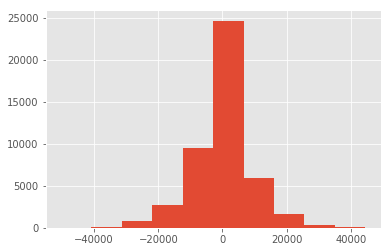

In [7]:
x['gold_diff'].hist()
plt.show()

Разбиение данных на обучающую и валидационную выборки

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_validation, y_train, y_validation = train_test_split(x, y, test_size=.33, random_state=1)

Заполнение пропусков нулями

In [9]:
x_train = x_train.fillna(0)
x_validation = x_validation.fillna(0)

Нормировка

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_validation = scaler.fit_transform(x_validation)

Список признаков, которые будут использованы в модели

In [11]:
features = list(x.columns)
print(features)

['lobby_type', 'r1_hero', 'r1_xp', 'r1_gold', 'r1_lh', 'r1_kills', 'r1_items', 'r2_hero', 'r2_xp', 'r2_gold', 'r2_lh', 'r2_kills', 'r2_items', 'r3_hero', 'r3_xp', 'r3_gold', 'r3_lh', 'r3_kills', 'r3_items', 'r4_hero', 'r4_xp', 'r4_gold', 'r4_lh', 'r4_kills', 'r4_items', 'r5_hero', 'r5_xp', 'r5_gold', 'r5_lh', 'r5_kills', 'r5_items', 'd1_hero', 'd1_xp', 'd1_gold', 'd1_lh', 'd1_kills', 'd1_items', 'd2_hero', 'd2_xp', 'd2_gold', 'd2_lh', 'd2_kills', 'd2_items', 'd3_hero', 'd3_xp', 'd3_gold', 'd3_lh', 'd3_kills', 'd3_items', 'd4_hero', 'd4_xp', 'd4_gold', 'd4_lh', 'd4_kills', 'd4_items', 'd5_hero', 'd5_xp', 'd5_gold', 'd5_lh', 'd5_kills', 'd5_items', 'radiant_bottle_time', 'radiant_courier_time', 'radiant_flying_courier_time', 'radiant_tpscroll_count', 'radiant_boots_count', 'radiant_ward_observer_count', 'radiant_ward_sentry_count', 'radiant_first_ward_time', 'dire_bottle_time', 'dire_courier_time', 'dire_flying_courier_time', 'dire_tpscroll_count', 'dire_boots_count', 'dire_ward_observer

Обучение случайного леса из 100 деревьев с максимальной глубиной дерева равной 5.

In [12]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=322)
clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=322, verbose=0, warm_start=False)

Оценка качества модели

In [13]:
from sklearn.metrics import accuracy_score

print('Train Accuracy:', accuracy_score(y_train, clf.predict(x_train)))
print('Validation Accuracy:', accuracy_score(y_validation, clf.predict(x_validation)))

Train Accuracy: 0.5940446004811131
Validation Accuracy: 0.5867212249208026


Важность признаков

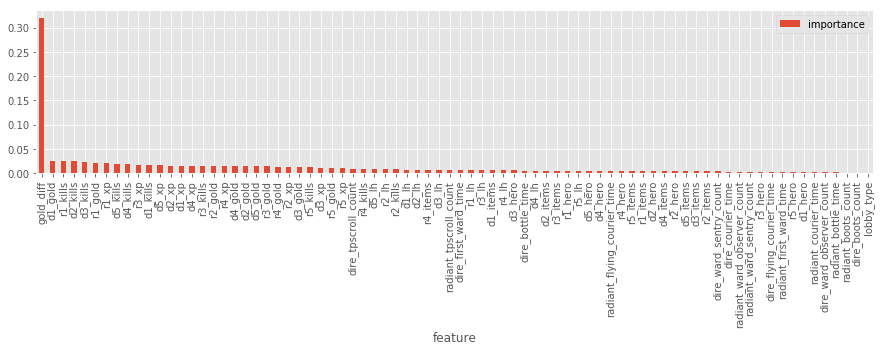

,importance
feature,
gold_diff,0.320465
d1_gold,0.025631
r1_kills,0.024626
d2_kills,0.024260
d3_kills,0.022994


In [14]:
if hasattr(clf, 'coef_'):
    df_importances = sorted(list(zip(x.columns, clf.coef_.ravel())), key=lambda tpl: tpl[1], reverse=True)
else:
    df_importances= sorted(list(zip(x.columns, clf.feature_importances_.ravel())), key=lambda tpl: tpl[1], reverse=True)
df_importances = pd.DataFrame(df_importances, columns=['feature', 'importance'])
df_importances = df_importances.set_index('feature')
df_importances.plot(kind='bar', figsize=(15, 3))
plt.show()
display(df_importances.head())

# Отправка результатов на проверку

## Загрузка данных
- x_test - тестовый набор данных
- y_submission - прогноз для тестовой выборки, который отправляется на проверку

In [20]:
x_test = pd.read_csv('data/test.csv', index_col=0)
y_submission = pd.read_csv('data/submission.csv', index_col=0)

При скоринге обученной моделью нового набора данных, необходимо повторить все преобразования, которые были использованы в процессе подготовки обучающей выборки.

Добавляем новые признаки

In [21]:
x_test['radiant_gold'] = x_test['r1_gold'] + x_test['r2_gold'] + x_test['r3_gold'] + x_test['r4_gold'] + x_test['r5_gold']
x_test['dire_gold'] = x_test['d1_gold'] + x_test['d2_gold'] + x_test['d3_gold'] + x_test['d4_gold'] + x_test['d5_gold']
x_test['gold_diff'] = x_test['radiant_gold'] - x_test['dire_gold']
x_test.drop(['radiant_gold', 'dire_gold'], axis=1, inplace=True)

Заполняем пропуски в данных

In [22]:
x_test = x_test.fillna(0)

Сохраняем только те признаки, которые использовались при обучении

In [23]:
x_test = x_test[features]

Нормируем

In [24]:
scaler = MinMaxScaler()
x_test = scaler.fit_transform(x_test)

Прогноз

In [25]:
y_submission['radiant_won'] = clf.predict(x_test)

Сохраняем прогноз на диск в папку submissions. Имя прогноза соответсвует дате и времени его создания, закодированными с помощью [timestamp](https://www.epochconverter.com/).

In [26]:
import time
import os

current_timestamp = int(time.time())
submission_path = 'submissions/{}.csv'.format(current_timestamp)

if not os.path.exists('submissions'):
    os.makedirs('submissions')

print(submission_path)
y_submission.to_csv(submission_path, index=True)

submissions/1520800774.csv
